# Image Classification with ANN


## Step 1: Import Libraries

In [3]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [4]:
#!pip install tensorflow==2.0.0

In [5]:
# import libraries and packages

import numpy as np
import random
import pickle
import cv2
import os
import time
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

from imutils import paths
from tqdm import tqdm_notebook as tqdm
import itertools

SEED = 42

## Step 2 : Loading the data

In [6]:
# change the current working directory
os.chdir('/content/drive/MyDrive/ImageClassificationWithANN')

In [7]:
!dir

ANN_imageClassification.h5  dataset.rar			      test_examples
dataset			    ImageClassificationWithANN.ipynb  test_examples.rar


In [8]:
# to extract the .rar files
#!pip install patool

In [51]:
#import patoolib
#patoolib.extract_archive('dataset.rar')
#patoolib.extract_archive('test_examples.rar')

In [11]:
image_pat = list(paths.list_images('dataset'))[:1]

In [13]:
# Initialize data and labels

print('[INFO] Loading Images...')
time_now = time.time()
data = [] #store pixel intensity
labels = [] #store output labels
classes = ['Forest','Buildings']

# initialize image paths

image_paths = sorted(list(paths.list_images('dataset')))
random.seed(SEED)
random.shuffle(image_paths)

# start tqdm loop for progress bar
with tqdm(total = len(image_paths)) as pbar:

    # loop over input images
    for image_path in image_paths:
        image = cv2.imread(image_path)
        image = cv2.resize(image,(32,32)).flatten()
        data.append(image)

        # extract class label from the image
        label = image_path.split(os.path.sep)[-2]

        # extract the class labels from paths
        label = 1 if label=='Buildings' else 0
        labels.append(label)

        # update progressbar
        pbar.update(1)

# scale the intensities ranging from 0-1 [ex. 140/255 = 0.5490]
data = np.array(data, dtype = 'float')/255.0
labels = np.array(labels)

print('Execution successful in {:.1f} seconds.'.format(time.time() - time_now))

[INFO] Loading Images...


  0%|          | 0/883 [00:00<?, ?it/s]

Execution successful in 108.1 seconds.


In [14]:
(data)

array([[0.31764706, 0.29803922, 0.28627451, ..., 0.74117647, 0.58823529,
        0.4627451 ],
       [0.46666667, 0.38039216, 0.03137255, ..., 0.51372549, 0.51372549,
        0.09411765],
       [0.53333333, 0.95686275, 0.8745098 , ..., 0.05882353, 0.18039216,
        0.23137255],
       ...,
       [0.98039216, 0.83529412, 0.73333333, ..., 0.18823529, 0.23529412,
        0.22745098],
       [0.81960784, 0.77647059, 0.74509804, ..., 0.61568627, 0.61176471,
        0.65098039],
       [0.00392157, 0.09803922, 0.        , ..., 0.06666667, 0.07058824,
        0.03137255]])

In [15]:
len(labels)

883

In [16]:
labels

array([0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,

# Step 3 : Train test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = SEED)

In [18]:
# convert the labels from integers to categorical

# as we have only 2 classes -  building [0,1] and forest [1,0]
# if the classes are 3 or more - building [0,0,1] forest [0,1,0] hills [1,0,0]
# add more numbe of columns as per classes

y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)


In [19]:
y_train

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

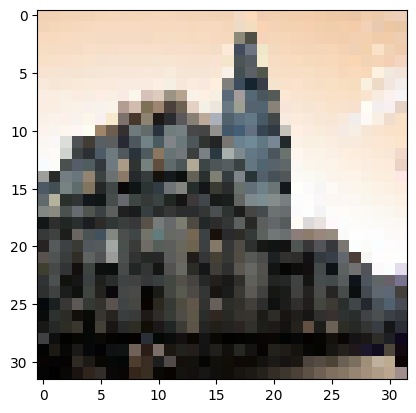

In [20]:
# view an image in 32x32
view_image = (X_train[5]*255).astype('int')
plt.imshow(view_image.reshape(32,32,3))

In [21]:
y_train[5]
# we can observe that its a building, but we need to build a model to predict soo

array([0., 1.], dtype=float32)

# Step 4 : Define the ANN Architecture

In [22]:
# defining the architecture = 3072-1024-512-2

model = Sequential()

# first layer (hidden) 1024 as there are 3072 input pixels in the flattened input image (32x32x3)
model.add(Dense(units = 1024, input_shape = (3072,), kernel_initializer = 'uniform', activation = 'relu'))

# second layer (hidden) of 1024
model.add(Dense(units = 512, kernel_initializer = 'uniform', activation = 'relu'))

# output layer of 2 units
model.add(Dense(units = 2,kernel_initializer = 'uniform', activation = 'softmax'))

# Step 5 : Compile the model

In [23]:
# Define learning rate and epochs

LR = 0.01
EPOCHS = 50

print('[INFO] Compiling the network...')

opt = SGD(learning_rate =LR)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = 'accuracy')

[INFO] Compiling the network...


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 3672578 (14.01 MB)
Trainable params: 3672578 (14.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Step 6 : Training the model

In [25]:
time_start = time.time()

H = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = EPOCHS, batch_size = 32)

print('Total time taken for training {:.1f}'.format(time.time() - time_start))

Epoch 1/50
23/23 [==============================] - 1s 23ms/step - loss: 0.6461 - accuracy: 0.5567 - val_loss: 0.6386 - val_accuracy: 0.5367
Epoch 2/50
23/23 [==============================] - 0s 16ms/step - loss: 0.6203 - accuracy: 0.5581 - val_loss: 0.6329 - val_accuracy: 0.8475
Epoch 3/50
23/23 [==============================] - 0s 16ms/step - loss: 0.6030 - accuracy: 0.6232 - val_loss: 0.5819 - val_accuracy: 0.6271
Epoch 4/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5737 - accuracy: 0.6402 - val_loss: 0.5623 - val_accuracy: 0.8079
Epoch 5/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5539 - accuracy: 0.7110 - val_loss: 0.5609 - val_accuracy: 0.8588
Epoch 6/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5340 - accuracy: 0.7620 - val_loss: 0.5230 - val_accuracy: 0.6554
Epoch 7/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5085 - accuracy: 0.7465 - val_loss: 0.4919 - val_accuracy: 0.8814
Epoch 8/50
23

# Step 7 : Evaluating the model

In [26]:
pred_prob = model.predict(X_test, batch_size = 32)
pred_prob

6/6 [==============================] - 0s 5ms/step


array([[9.41166759e-01, 5.88332713e-02],
       [9.99999225e-01, 7.34495245e-07],
       [3.39829057e-01, 6.60171032e-01],
       [9.99998868e-01, 1.05007962e-06],
       [9.73468125e-01, 2.65318416e-02],
       [9.99999940e-01, 3.19869926e-08],
       [3.08758646e-01, 6.91241264e-01],
       [9.95572150e-01, 4.42773663e-03],
       [9.99995649e-01, 4.29360580e-06],
       [9.99999940e-01, 1.35338532e-10],
       [9.76817548e-01, 2.31824629e-02],
       [9.99097645e-01, 9.02312924e-04],
       [9.96246219e-01, 3.75379622e-03],
       [9.99941766e-01, 5.81534587e-05],
       [9.91430938e-01, 8.56907200e-03],
       [9.96029437e-01, 3.97053594e-03],
       [9.18071389e-01, 8.19286481e-02],
       [1.64328486e-01, 8.35671544e-01],
       [9.99999702e-01, 2.34764912e-07],
       [7.10561037e-01, 2.89438963e-01],
       [9.99847412e-01, 1.52694527e-04],
       [9.98803735e-01, 1.19625253e-03],
       [9.98669505e-01, 1.33054180e-03],
       [5.69943249e-01, 4.30056781e-01],
       [1.954256

In [27]:
#convert the above array into int (0,1)

y_test = [np.argmax(i) for i in y_test]
y_pred = [np.argmax(i) for i in pred_prob]

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.98      0.72        82
           1       0.95      0.38      0.54        95

    accuracy                           0.66       177
   macro avg       0.76      0.68      0.63       177
weighted avg       0.78      0.66      0.63       177



In [29]:
print(accuracy_score(y_test, y_pred))

0.655367231638418


# Step 8 : Saving the model

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 3672578 (14.01 MB)
Trainable params: 3672578 (14.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.save('ANN_imageClassification.h5')

In [31]:
!dir

ANN_imageClassification.h5  dataset.rar			      test_examples
dataset			    ImageClassificationWithANN.ipynb  test_examples.rar


# Step 9 : Visualizing the loss, Why ANN is bad for image classification

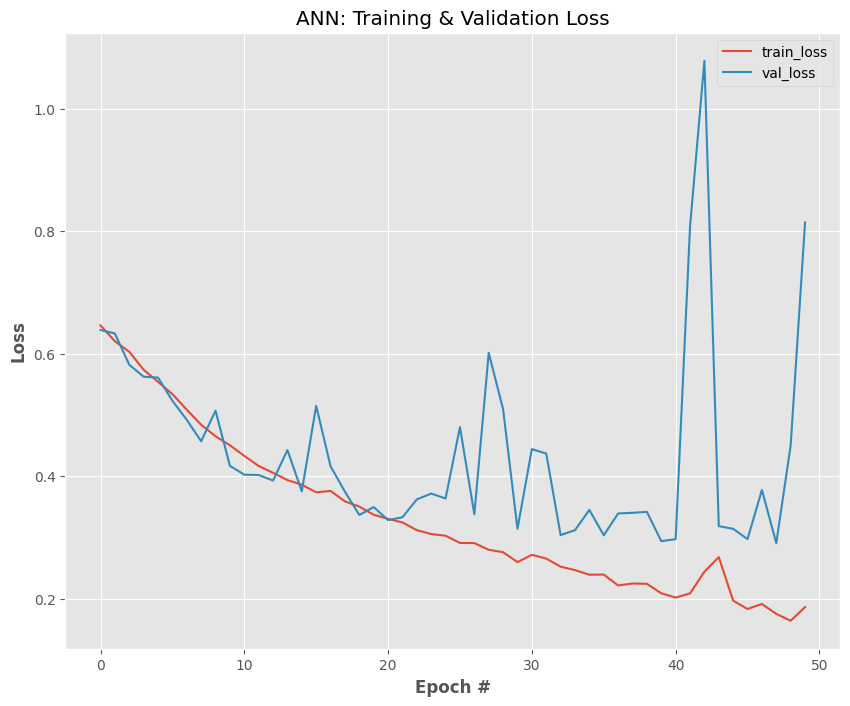

In [32]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("ANN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

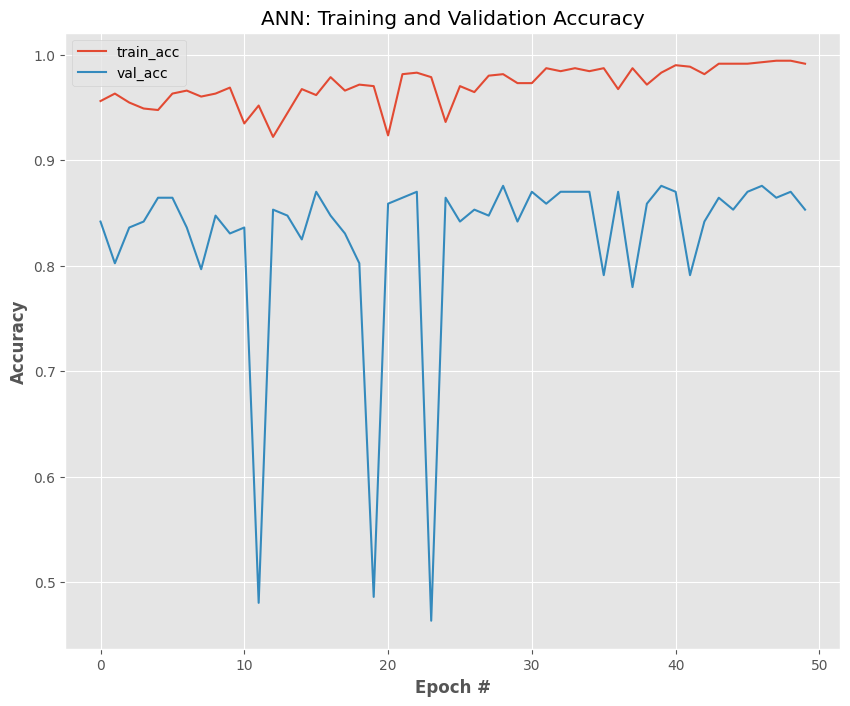

In [75]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("ANN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

# Step 10 : Making predictions on unseen data

In [33]:
#!pip install imutils
import imutils

In [39]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    plt.grid()
    ax = fig.add_subplot(111)
    ax.imshow(img)

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


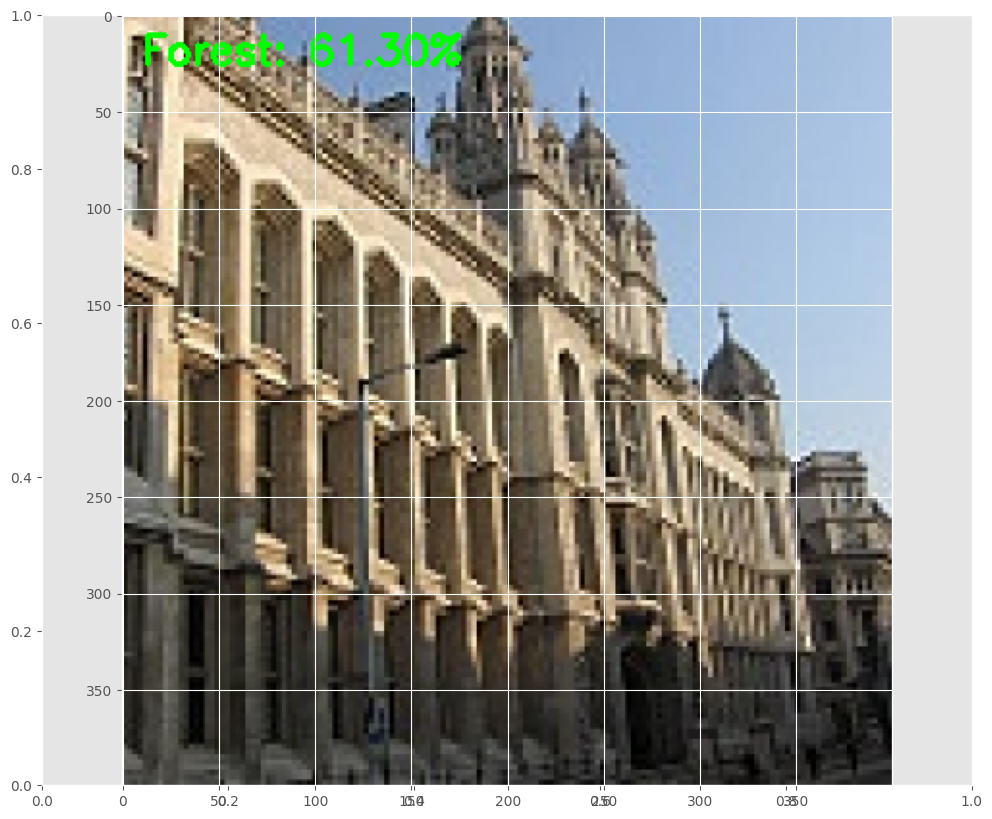

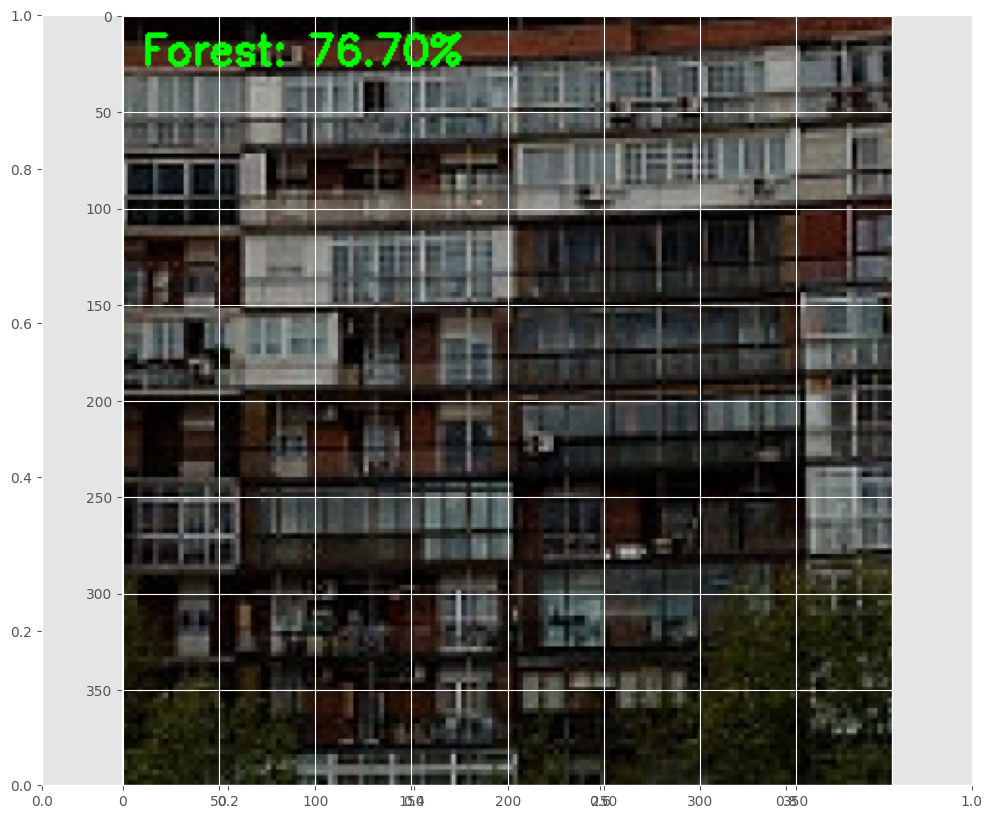

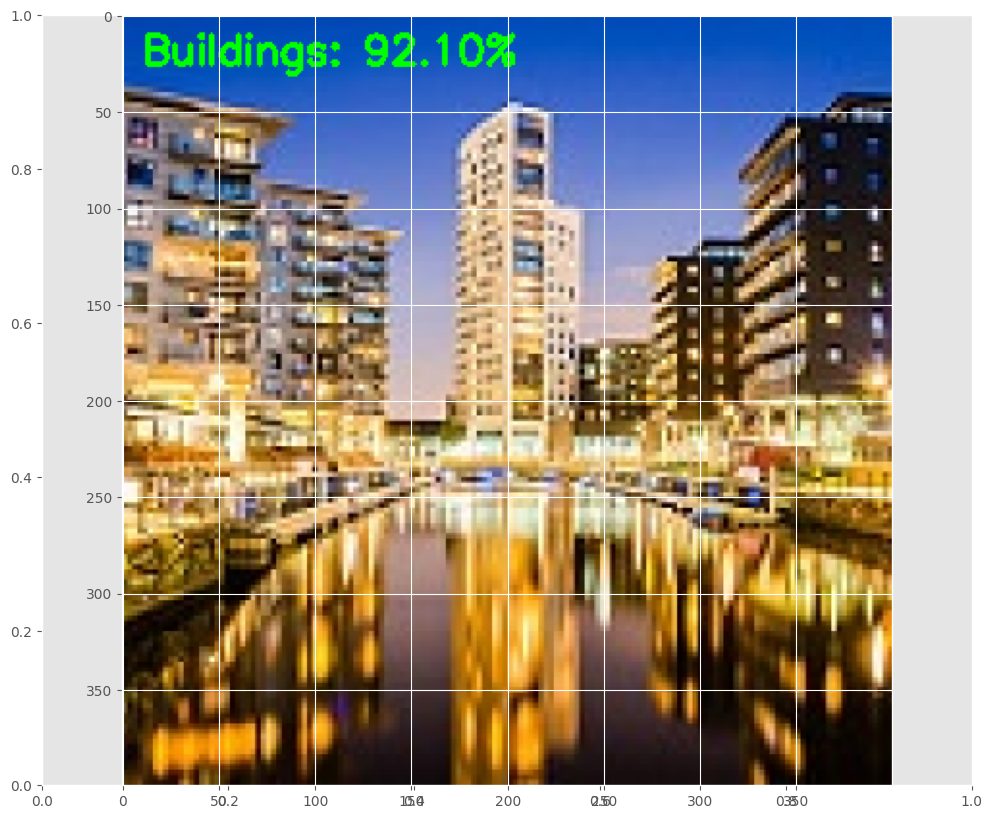

In [46]:
# load the input image and resize it to the target spatial dimensions
width = 32
height = 32

# grab the image paths and randomly shuffle them
testImagePaths = sorted(list(paths.list_images('test_examples'))[:3])  # test data folder with random images


# progress bar
with tqdm(total=len(testImagePaths)) as pbar:

    for imagePath in testImagePaths:
        image = cv2.imread(imagePath)
        output = image.copy()
        image = cv2.resize(image, (width, height))

        # scale the pixel values to [0, 1]
        image = image.astype("float") / 255.0

        # for a simple fully-connected network, flatten the image
        image = image.flatten()
        image = image.reshape((1, image.shape[0]))


        # make a prediction on the image
        preds = model.predict(image)

        # find the class label index with the largest corresponding probability
        i = preds.argmax(axis=1)[0]
        label = classes[i]

        label = "{}: {:.2f}%".format(label, preds[0][i] * 100)


        output = imutils.resize(output, width=400)
        cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (0, 255, 0), 2)

        # convert img to rgb format and display in noteboo
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)

#         print("############################")
#         print("image: {}".format(os.path.split(imagePath)[-1]))
#         print("predicted label: {}".format(label))
#         print("Confidence: {}".format(preds[0][i]))

        pbar.update(1)